https://laid-back-scientist.com/k-means
https://laid-back-scientist.com/k-means

In [1]:
import timm
from PIL import Image
import torch
from torchvision import transforms
from torch.nn import functional as F
import timm.models.mlp_mixer
import numpy as np
import exchange_tensor_array as exchange
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision.datasets.utils import download_url
import json

import copy
#モデル作成
model = timm.create_model("gmlp_s16_224", pretrained=True)
model.eval()
print("model")

transform = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
        transforms.ToTensor(),  # テンソルにする。
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # 標準化する。
    ]
)

transform_beta = transforms.Compose(
    [
        transforms.Resize(256),  # (256, 256) で切り抜く。
        transforms.CenterCrop(224),  # 画像の中心に合わせて、(224, 224) で切り抜く
    ]
)

img = Image.open("cat.jpg")
inputs = transform(img)
inputs = inputs.unsqueeze(0)
#plt.imshow(inputs[0].permute(1,2,0))
copy_inputs = copy.deepcopy(inputs)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model


In [2]:
from sklearn.cluster import KMeans
from collections import defaultdict
from scipy.spatial import ConvexHull, Delaunay

class mid_output_k_meams_ablation():
    
    def __init__(self, model : timm.models.mlp_mixer.MlpMixer) -> None:
        self.model = model
        self.class_names = None
        self.get_classes()
        self.inputs = []
        self.values = []
        self.block_output = None
        self.block_output_exchanged = None
        self.points = None
        self.K = 10
        self.clusters = None
        self.dd = defaultdict(lambda : [])
        self.left = defaultdict(lambda : 1000)
        self.right = defaultdict(lambda : -1000)
        self.up = defaultdict(lambda : 1000)
        self.down = defaultdict(lambda : -1000)
        self.input_backup = defaultdict(lambda : []) # r, b, g
        self.masked_input = []
        self.border = 3.5
        
    def get_classes(self):
        if not Path("data/imagenet_class_index.json").exists():
            # ファイルが存在しない場合はダウンロードする。
            download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

        # クラス一覧を読み込む。
        with open("data/imagenet_class_index.json") as f:
            data = json.load(f)
            self.class_names = [x["ja"] for x in data]
    
    def base_model_output(self, _input : torch.Tensor) -> tuple:
        """画像をモデルに入力した際の一番スコアが高いラベルとそのスコアを返す"""
        base_output = self.model(_input)
        batch_probs = F.softmax(base_output, dim=1)
        batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

        return (self.class_names[batch_indices[0][0]], batch_probs[0][0].item())
    
    def in_hull_(self, point : list, hull : list):
        """点群hullからなる凸包内に点pointが入っているかを判定"""
        if not isinstance(hull, Delaunay):
            hull = Delaunay(hull)
        return hull.find_simplex(point) >= 0
    
    def calc_value(self, _input : torch.Tensor, K = 10) -> np.ndarray: 
        """
        入力画像に対して、最初の中間層において値の絶対値が閾値より大きいものに対してk-means法によるクラスタリングを行い、
        各クラスタによって形成される凸包単位でのマスクを行った際のスコアの変化を予測への寄与とする
        寄与度は元々のスコアをx, (i,j)要素を0にした際のスコアをyijとしたとき、(yij - x) / xとする
        """
        #print(len(np.where(inputs != _input)))
        #クラスタ数
        self.K = K
        
        #スコア記録用配列
        tmp_values = np.zeros((224, 224))
        
        self.masked_input = []
        count = 0
        
        #元々のスコアとクラス名とそのインデックスを取得
        self.base_class_name, self.base_prob = self.base_model_output(_input)
        self.base_class_index = self.class_names.index(self.base_class_name)
        
        #最初の中間層を取得
        self.block_output = self.model.blocks[0].block_output
        self.block_output_exchanged = exchange.exchange_tensor_to_array(self.block_output)
        
        #最初の中間層から値の絶対値が閾値より大きいものの座標を取得
        y, x = np.where(abs(self.block_output_exchanged) > self.border)
        L = len(y)
        self.points = [ [y[i], x[i]] for i in range(L)]
        
        #k-means法でクラスタリング
        self.k_means_model = KMeans(n_clusters=self.K)
        self.k_means_model.fit(self.points)
        self.clusters = self.k_means_model.predict(self.points)
        
        #クラスタ番号をキーとするdefaultdictに各点の座標を格納。y, x座標の最大値最小値も記録
        self.dd = defaultdict(lambda : [])
        self.left = defaultdict(lambda : 1000)
        self.right = defaultdict(lambda : -1000)
        self.up = defaultdict(lambda : 1000)
        self.down = defaultdict(lambda : -1000)
        for i in range(L):
            c = self.clusters[i]
            tmp_y, tmp_x = self.points[i]
            self.dd[c].append([tmp_y, tmp_x])
            self.left[c] = min(self.left[c], tmp_x)
            self.right[c] = max(self.right[c], tmp_x)
            self.up[c] = min(self.up[c], tmp_y)
            self.down[c] = max(self.down[c], tmp_y)
        
        #クラスタ毎に凸包を算出し、マスクしてモデルに流して評価値を得る
        for c in range(self.K):
            if len(self.dd[c]) < 3:
                continue
            #入力記録用の辞書を初期化しておく
            self.input_backup = defaultdict(lambda : []) # r, b, g
            
            #クラスタ毎にマスクする
            for y in range(self.up[c], self.down[c] + 1):
                for x in range(self.left[c], self.right[c] + 1):
                    tmp_p = [y, x]
                    if tmp_p in self.points:
                        count += 1
                    if self.in_hull_(point=tmp_p, hull=self.dd[c]):
                        r, b, g = _input[0, 0, y, x].item(), _input[0, 1, y, x].item(), _input[0, 2, y, x].item()
                        #r, b, g = _input[0, 0, y, x], _input[0, 1, y, x], _input[0, 2, y, x]
                        self.input_backup[(y, x)] = [r, b, g]
                        _input[0, 0, y, x] = 255
                        _input[0, 1, y, x] = 255
                        _input[0, 2, y, x] = 255
            
            #plt.imshow(_input[0].permute(1, 2, 0))
            
            #モデルに流してスコアを得る
            
            tmp_output = self.model(_input)
            tmp_batch_probs = F.softmax(tmp_output, dim = 1)
            tmp_prob = tmp_batch_probs[0][self.base_class_index].item()
            tmp_value = tmp_prob
            #tmp_value = (tmp_prob - self.base_prob) / self.base_prob
            self.masked_input.append(tmp_value)
            """
            for i in range(10):
                tmp_output = self.model(_input)
                tmp_batch_probs = F.softmax(tmp_output, dim = 1)
                tmp_prob = tmp_batch_probs[0][self.base_class_index].item()
                tmp_value = (tmp_prob - self.base_prob) / self.base_prob
                self.masked_input.append(tmp_value)
            """
            #スコアを記録すると共に入力を元に戻す
            for k, v in reversed(self.input_backup.items()):
                y, x = k
                r, b, g = v
                tmp_values[y, x] = tmp_value
                _input[0, 0, y, x] = r
                _input[0, 1, y, x] = b
                _input[0, 2, y, x] = g
            
            l = len(np.where(copy_inputs != _input))
            if l != 0:
                print(l)
            else:
                print("same!")
            #self.inputs.append(_input)
            #self.values.append(tmp_values)
        #plt.imshow(tmp_values) 
        print(count)  
        return tmp_values    
                        
            
            
        

In [3]:
exp = mid_output_k_meams_ablation(model)

In [17]:
exp_out = exp.calc_value(inputs, K = 4)

4
4
4
4
125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


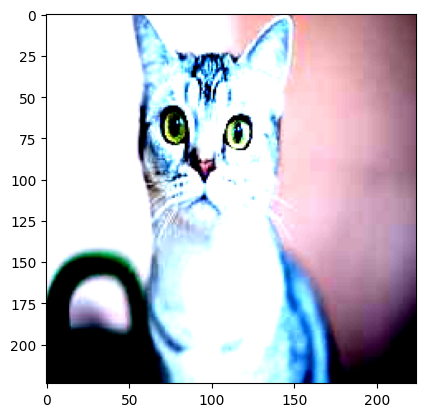

In [13]:
plt.imshow(copy_inputs[0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


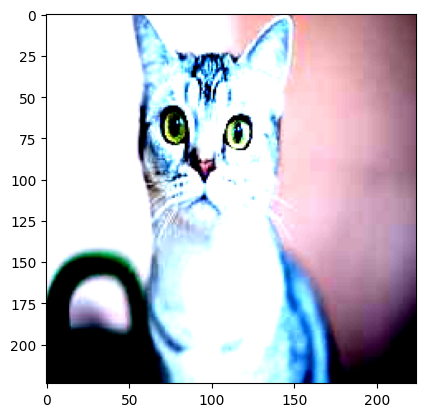

In [18]:
plt.imshow(inputs[0].permute(1, 2,0))

In [7]:
print(exp.up.items())
print(exp.down.items())
print(exp.left.items())
print(exp.right.items())

dict_items([(0, 26), (2, 124), (1, 140)])
dict_items([(0, 124), (2, 220), (1, 221)])
dict_items([(0, 51), (2, 1), (1, 78)])
dict_items([(0, 135), (2, 63), (1, 175)])


In [15]:
exp.masked_input

[0.762076199054718, 0.7078948020935059, 0.79424649477005]

In [9]:
exp_out.max()

0.79424649477005

In [10]:
max(exp.masked_input)

0.79424649477005

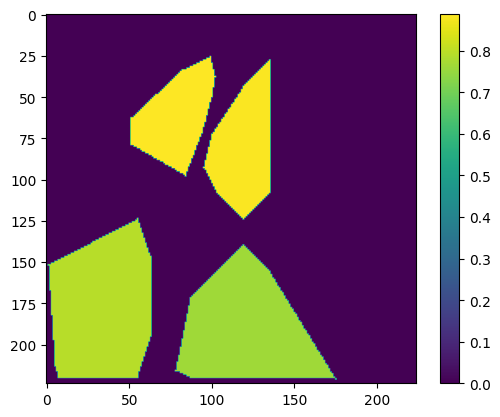

In [19]:
exchange.show_heatmap_with_colorbar(exp_out)

In [20]:
output = model(inputs)

block_outputs = []
block_outputs_exchanged = []
#ブロックの入出力の抽出
for i in model.blocks:
    _output = i.block_output
    block_outputs.append(_output)
    block_outputs_exchanged.append(exchange.exchange_tensor_to_array(_output))

In [ ]:
exchange.show_heatmap_with_colorbar(block_outputs_exchanged[0])

In [ ]:
exchange.show_heatmap_with_colorbar(tmp)

117


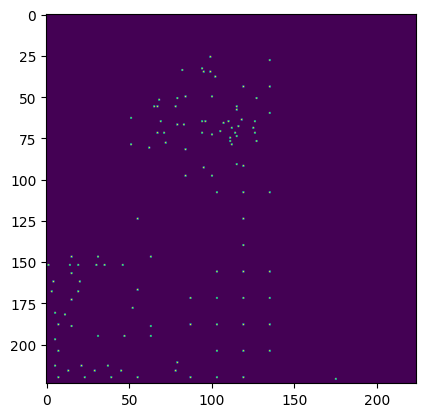

In [21]:
tmp = copy.deepcopy(block_outputs_exchanged[0])
count = 0
for i in range(224):
    for j in range(224):
        if abs(tmp[i, j]) > 3.5:
            count += 1
            tmp[i,j] = 255
        else:
            tmp[i, j] = 0
print(count)
plt.imshow(tmp)

In [ ]:
plt.imshow(inputs[0].permute(1, 2, 0))

In [23]:
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=3)
x = np.where(abs(tmp) > 2)
l = len(x[0])
p = [ [x[0][i], x[1][i]] for i in range(l)]
kmeans_model.fit(p)


KMeans(n_clusters=3)

In [24]:
clusters = kmeans_model.predict(p)

In [ ]:
len(p)

In [55]:
result = np.zeros((224, 224))
for i in range(l):
    y, x = p[i]
    result[y, x] = (clusters[i] + 1) * 50

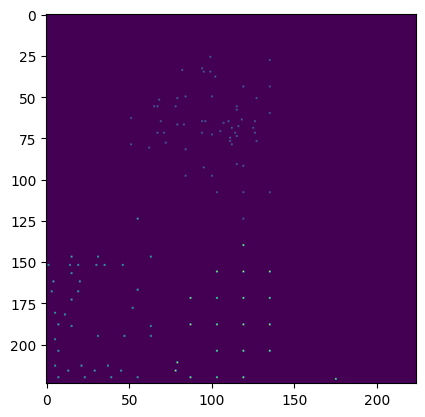

In [56]:
plt.imshow(result)

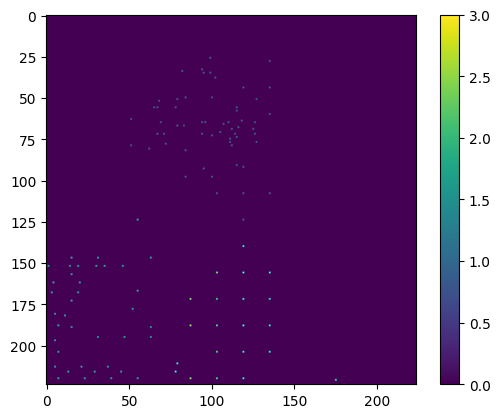

In [28]:
exchange.show_heatmap_with_colorbar(result)

In [30]:
import collections
dd = collections.defaultdict(lambda : [])
for i in range(l):
    y, x = p[i]
    c = clusters[i]
    dd[c].append([y, x])


In [31]:
from scipy.spatial import ConvexHull, Delaunay
hull = ConvexHull(dd[1])

In [ ]:
hull

In [32]:
def in_hull(point, hull):
    if not isinstance(hull, Delaunay):
        hull = Delaunay(hull)
    return hull.find_simplex(point) >= 0

In [ ]:
in_hull([0, 0], dd[1])

In [ ]:
len(dd)

In [ ]:
points = np.array(dd[1])
plt.scatter(points[:, 0], points[:,1])
points = np.array(dd[0])
plt.scatter(points[:, 0], points[:,1])
plt.show()
"""
hull = ConvexHull(points)
points = hull.points
hull_points = points[hull.vertices]

hp = np.vstack((hull_points, hull_points[0]))
plt.plot(hp[:,0], hp[:,1])
plt.scatter(points[:,0], points[:,1])
plt.show()
"""

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

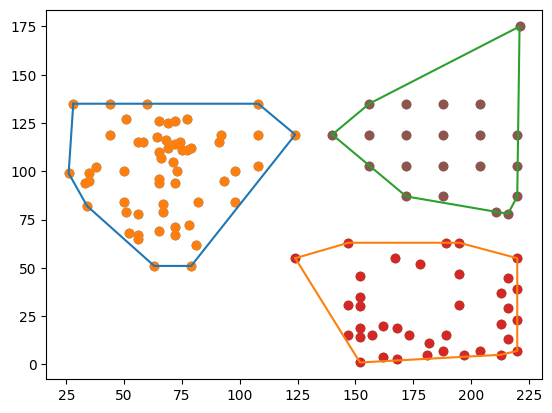

In [33]:
for c in range(6):
    points = np.array(dd[c])
    plt.scatter(points[:, 0], points[:,1])
    hull = ConvexHull(points)
    points = hull.points
    hull_points = points[hull.vertices]

    hp = np.vstack((hull_points, hull_points[0]))
    plt.plot(hp[:,0], hp[:,1])
    plt.scatter(points[:,0], points[:,1])
plt.show()

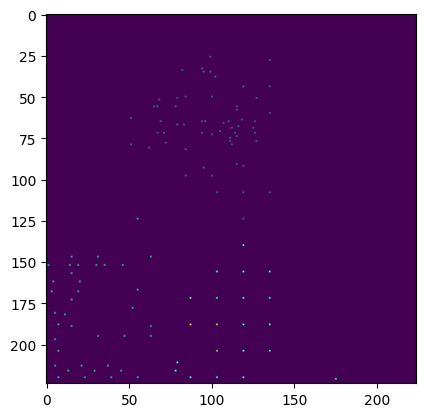

In [54]:
flags = np.zeros((224, 224))
for c in range(3):
    ys = [ dd[c][i][0] for i in range(len(dd[c]))]
    xs = [ dd[c][i][1] for i in range(len(dd[c]))]
    
    for y, x in zip(ys, xs):
        flags[y, x] = (c + 1) * 50+ 1
plt.imshow(flags)

In [35]:
flags = np.zeros((224, 224))
for c in range(3):
    ys = [ dd[c][i][0] for i in range(len(dd[c]))]
    xs = [ dd[c][i][1] for i in range(len(dd[c]))]
    left = min(xs)
    right = max(xs)
    up = min(ys)
    down = max(ys)
    for y in range(up, down + 1):
        for x in range(left, right + 1):
            if in_hull([y, x], dd[c]):
                flags[y, x] = c + 1

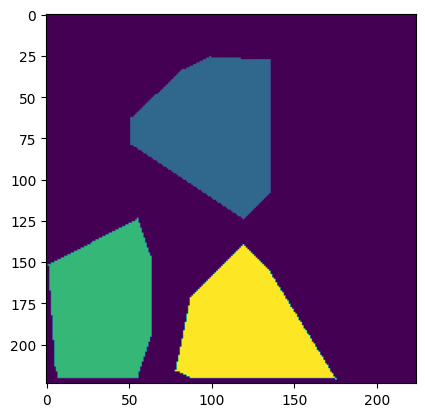

In [36]:
plt.imshow(flags)

In [ ]:
ys = [ dd[3][i][0] for i in range(len(dd[3]))]
xs = [ dd[3][i][1] for i in range(len(dd[3]))]
left = min(xs)
right = max(xs)
up = min(ys)
down = max(ys)

In [ ]:
print(left, right, up, down)

In [ ]:
flags = np.zeros((224, 224))
for y in range(up, down + 1):
    for x in range(left, right + 1):
        test = [y, x]
        if in_hull(test, dd[3]):
            flags[y, x] = 255
        

In [ ]:
plt.imshow(flags)

In [ ]:
def get_classes():
    if not Path("data/imagenet_class_index.json").exists():
        # ファイルが存在しない場合はダウンロードする。
        download_url("https://git.io/JebAs", "data", "imagenet_class_index.json")

    # クラス一覧を読み込む。
    with open("data/imagenet_class_index.json") as f:
        data = json.load(f)
        return [x["ja"] for x in data]

class_names = get_classes()
def base_model_output(_input : torch.Tensor) -> tuple:
    """画像をモデルに入力した際の一番スコアが高いラベルとそのスコアを返す"""
    base_output = model(_input)
    batch_probs = F.softmax(base_output, dim=1)
    batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

    return (class_names[batch_indices[0][0]], batch_probs[0][0])


target_class_name, base_probs = base_model_output(inputs)
class_index = class_names.index(target_class_name)

In [ ]:
base_probs

In [ ]:
class_index

In [ ]:
import collections
dd = collections.defaultdict(lambda : [])
for i in range(l):
    y, x = p[i]
    c = clusters[i]
    dd[c].append([y, x])
values = np.zeros((224, 224))
stack = collections.defaultdict(lambda : 0)
for i in dd.values()[1:]:
    for y, x in i:
        stack[(y, x, 0)] = inputs[0, 0, y, x].item()
        stack[(y, x, 1)] = inputs[0, 1, y, x].item()
        stack[(y, x, 2)] = inputs[0, 2, y, x].item()
        inputs[0, 0, y, x] = 0
        inputs[0, 1, y, x] = 0
        inputs[0, 2, y, x] = 0
    plt.imshow(inputs[0].permute(1,2,0))
    exit()
    tmp_output = model(inputs)
    batch_probs = F.softmax(output, dim=1)
    tmp_prob = batch_probs[0][class_index].item()
    tmp_value = tmp_prob - base_probs
    print(tmp_prob)
    for y, x in i:
        values[y, x] = tmp_value
        r, b, g = stack[(y, x, 0)], stack[(y, x, 1)], stack[(y, x, 2)]
        inputs[0, 0, y, x] = r
        inputs[0, 1, y, x] = b
        inputs[0, 2, y, x] = g
plt.imshow(inputs[0].permute(1,2,0))

In [ ]:
exchange.show_heatmap_with_colorbar(values)

In [ ]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(p, columns=["y", "x"])
df["class"] = clusters
sns.scatterplot(data=df, x="x", y="y",hue="class")